# 03 – Time Series Analysis: Decomposition and Linear Trend

In this notebook you will:

1. Check that the required Python modules are installed.  
2. Load a CSV file containing a **time series** (date + value).  
3. Select one **date column** and one **quantitative value column**.  
4. Convert the date column to a proper datetime index and sort the series in time order.  
5. Optionally **decompose** the time series into trend, seasonality and residuals.  
6. Fit a **linear trend** using simple regression and visualize it together with the original series.  

This is designed for historical time series (e.g. yearly or monthly data about prices, populations, trade, etc.).


In [5]:
# Step 1: check and import required modules

print("Step 1: Checking required Python modules...")

required_modules = ["pandas", "numpy", "matplotlib", "statsmodels"]
missing = []

for m in required_modules:
    try:
        __import__(m)
    except ImportError:
        missing.append(m)

if missing:
    print("\nThe following required modules are missing:")
    for m in missing:
        print("  -", m)
    print("\nPlease install them before continuing, for example:")
    print("  pip install " + " ".join(missing))
else:
    print("All required modules are available. Proceeding...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

print("Modules successfully imported: pandas, numpy, matplotlib, statsmodels.")


Step 1: Checking required Python modules...
All required modules are available. Proceeding...
Modules successfully imported: pandas, numpy, matplotlib, statsmodels.


In [6]:
# Step 2: load a CSV file containing a time series

print("Step 2: Loading the data from a CSV file.")
print("Please provide:")
print("- The name (or path) of the CSV file, including the extension (e.g. 'data.csv' or 'data/prices.csv').")
print("- Later you will choose one DATE column and one QUANTITATIVE column.")
print("IMPORTANT: include the file extension, e.g. '.csv'.")

df = None

while df is None:
    csv_path = input("Enter the CSV file name or path (e.g. data.csv): ").strip()
    if not csv_path:
        print("You did not enter a file name. Please try again.\n")
        continue

    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"File not found: {csv_path}")
        print("Please check that:")
        print("- The file is in the current working directory OR you used the correct relative path;")
        print("- You included the correct extension, e.g. '.csv'.")
        print("Try again.\n")
        df = None
    except Exception as e:
        print(f"An unexpected error occurred while reading the file: {e}")
        print("Please fix the problem (e.g. encoding, separator) and try again.\n")
        df = None

print(f"\nData loaded successfully from: {csv_path}")
print("The first 5 rows of the dataset:")
display(df.head())

print("\nColumn names in this dataset:")
print(list(df.columns))


Step 2: Loading the data from a CSV file.
Please provide:
- The name (or path) of the CSV file, including the extension (e.g. 'data.csv' or 'data/prices.csv').
- Later you will choose one DATE column and one QUANTITATIVE column.
IMPORTANT: include the file extension, e.g. '.csv'.


Enter the CSV file name or path (e.g. data.csv):  AMZN.csv



Data loaded successfully from: AMZN.csv
The first 5 rows of the dataset:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-16,1773.33,1786.24,1770.52,1777.43,1777.43,2763400
1,2019-10-17,1796.49,1798.85,1782.02,1787.48,1787.48,2647400
2,2019-10-18,1787.80,1793.98,1749.20,1757.51,1757.51,3362500
3,2019-10-21,1769.66,1785.88,1765.00,1785.66,1785.66,2130400
4,2019-10-22,1788.15,1789.78,1762.00,1765.73,1765.73,2111700



Column names in this dataset:
['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [7]:
# Step 3: choose date column and value column

print("Step 3: Choose one DATE column and one QUANTITATIVE column.")

def ask_for_column(prompt):
    while True:
        col = input(prompt).strip()
        if col in df.columns:
            return col
        print(f"Column '{col}' was not found in the dataset. Please try again.")
        print("Available columns:")
        print(list(df.columns))

date_col = ask_for_column("Enter the name of the DATE column: ")
value_col = ask_for_column("Enter the name of the VALUE (quantitative) column: ")

ts_df = df[[date_col, value_col]].copy()

print(f"\nWe will now work with:")
print(f"- Date column:  {date_col}")
print(f"- Value column: {value_col}")

# Convert date column to datetime
print("\nConverting the date column to datetime format...")
ts_df[date_col] = pd.to_datetime(ts_df[date_col], errors="coerce")

num_invalid = ts_df[date_col].isna().sum()
if num_invalid > 0:
    print(f"Warning: {num_invalid} rows have invalid or missing dates and will be dropped.")
    ts_df = ts_df.dropna(subset=[date_col])

# Sort by date and set index
ts_df = ts_df.sort_values(by=date_col)
ts_df = ts_df.set_index(date_col)

# Convert value column to numeric (in case it was stored as text)
if not np.issubdtype(ts_df[value_col].dtype, np.number):
    print(f"Column '{value_col}' is not numeric. Trying to convert it to numeric (invalid values become NaN)...")
    ts_df[value_col] = pd.to_numeric(ts_df[value_col], errors="coerce")

# Drop rows with missing values in the value column
ts_df = ts_df.dropna(subset=[value_col])

print("\nBasic information about the time series after cleaning:")
display(ts_df.info())

print("\nFirst 10 observations:")
display(ts_df.head(10))


Step 3: Choose one DATE column and one QUANTITATIVE column.


Enter the name of the DATE column:  Date
Enter the name of the VALUE (quantitative) column:  Open



We will now work with:
- Date column:  Date
- Value column: Open

Converting the date column to datetime format...

Basic information about the time series after cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2019-10-16 to 2020-10-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    253 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


None


First 10 observations:


,Open
Date,
2019-10-16,1773.33
2019-10-17,1796.49
2019-10-18,1787.80
2019-10-21,1769.66
2019-10-22,1788.15
2019-10-23,1761.30
2019-10-24,1771.09
2019-10-25,1697.55
2019-10-28,1748.06


Step 4: Plotting the time series.


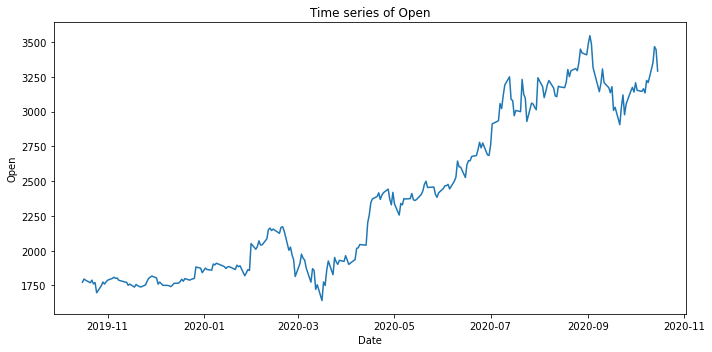

This plot shows how the selected value changes over time.


In [8]:
# Step 4: plot the time series

print("Step 4: Plotting the time series.")

x = ts_df.index.to_numpy()          # convert index to a 1D NumPy array
y = ts_df[value_col].to_numpy()     # convert series to a 1D NumPy array

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title(f"Time series of {value_col}")
plt.xlabel("Date")
plt.ylabel(value_col)
plt.tight_layout()
plt.show()

print("This plot shows how the selected value changes over time.")


Step 5: Time series decomposition (optional).
Decomposition requires you to specify a seasonal period, e.g.:
- 12 for monthly data with yearly seasonality;
- 4 for quarterly data with yearly seasonality;
- 7 for daily data with weekly seasonality, etc.
If you are not sure, you can press Enter to skip decomposition.


Enter the seasonal period (integer, or press Enter to skip):  12



Decomposition may still work, but interpret the seasonal component with caution.

Performing additive decomposition with period = 12...


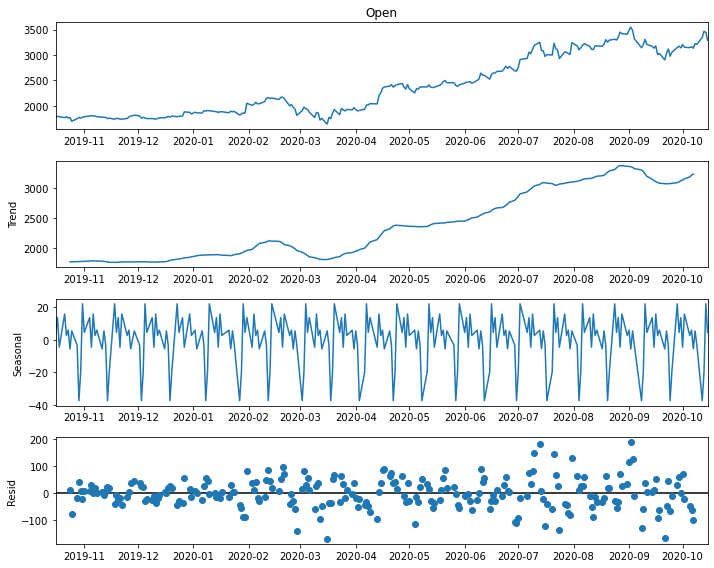

The decomposition plots show:
- The original series (top);
- The estimated trend;
- The seasonal component;
- The residual (random) component.


In [9]:
# Step 5: optional decomposition into trend, seasonality and residuals

print("Step 5: Time series decomposition (optional).")
print("Decomposition requires you to specify a seasonal period, e.g.:")
print("- 12 for monthly data with yearly seasonality;")
print("- 4 for quarterly data with yearly seasonality;")
print("- 7 for daily data with weekly seasonality, etc.")
print("If you are not sure, you can press Enter to skip decomposition.")

period_input = input("Enter the seasonal period (integer, or press Enter to skip): ").strip()

if period_input == "":
    print("No period specified. Skipping decomposition step.")
else:
    try:
        period = int(period_input)
        if period <= 1:
            raise ValueError("Period must be greater than 1.")
    except Exception as e:
        print(f"Invalid period: {e}. Skipping decomposition step.")
        period = None

    if period is not None:
        ts = ts_df[value_col]

        if ts.index.inferred_freq is None:
            print("\nWarning: pandas could not infer a clear frequency for the index.")
            print("Decomposition may still work, but interpret the seasonal component with caution.")

        print(f"\nPerforming additive decomposition with period = {period}...")
        result = seasonal_decompose(ts, model="additive", period=period)

        fig = result.plot()
        fig.set_size_inches(10, 8)
        plt.tight_layout()
        plt.show()

        print("The decomposition plots show:")
        print("- The original series (top);")
        print("- The estimated trend;")
        print("- The seasonal component;")
        print("- The residual (random) component.")


Step 6: Estimating a linear trend using simple regression.


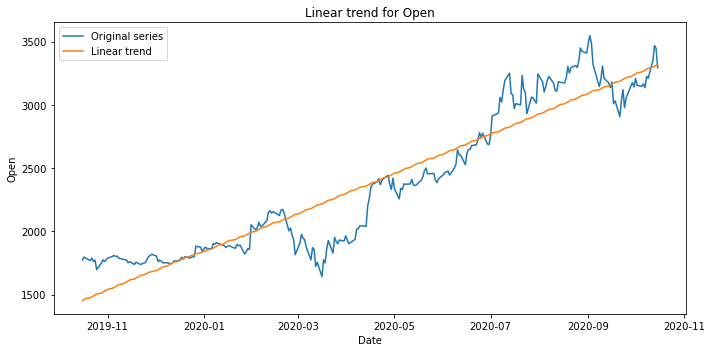

Estimated linear trend model (using a simple time index t = 0, 1, 2, ...):
Open ≈ 7.4080 * t + 1452.6046
Coefficient of determination R^2 for the trend model: 0.881

Interpretation tips:
- The coefficient 'a' (slope) tells you the average change in the series per time step;
- A positive slope indicates an upward trend, a negative slope a downward trend;
- R^2 indicates how well a linear trend approximates the series (values closer to 1 mean a better fit);
- Always interpret these results in the historical context of your data (events, reforms, wars, crises, etc.).


In [10]:
# Step 6: linear trend estimation using simple regression

print("Step 6: Estimating a linear trend using simple regression.")

ts = ts_df[value_col].dropna()

if len(ts) < 2:
    print("Not enough data points to estimate a trend (need at least 2).")
else:
    # Create a simple time index: 0, 1, 2, ..., n-1
    t = np.arange(len(ts))
    y = ts.to_numpy()

    # Fit linear regression y = a * t + b
    a, b = np.polyfit(t, y, 1)
    trend_values = a * t + b

    # Compute R^2
    ss_res = np.sum((y - trend_values) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

    # Plot original series and linear trend
    x_dates = ts.index.to_numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(x_dates, y, label="Original series")
    plt.plot(x_dates, trend_values, label="Linear trend")
    plt.title(f"Linear trend for {value_col}")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Estimated linear trend model (using a simple time index t = 0, 1, 2, ...):")
    print(f"{value_col} ≈ {a:.4f} * t + {b:.4f}")
    print(f"Coefficient of determination R^2 for the trend model: {r_squared:.3f}")
    print("\nInterpretation tips:")
    print("- The coefficient 'a' (slope) tells you the average change in the series per time step;")
    print("- A positive slope indicates an upward trend, a negative slope a downward trend;")
    print("- R^2 indicates how well a linear trend approximates the series (values closer to 1 mean a better fit);")
    print("- Always interpret these results in the historical context of your data (events, reforms, wars, crises, etc.).")


## Summary of what this notebook did

1. **Checked required modules** (`pandas`, `numpy`, `matplotlib`, `statsmodels`).  
2. **Loaded a CSV file** that you specified, containing at least one date column and one quantitative column.  
3. **Converted the date column to a datetime index**, sorted the data by date, and cleaned invalid dates or values.  
4. **Plotted the time series** using NumPy arrays for safety with newer versions of pandas/matplotlib.  
5. Optionally **decomposed the series** into trend, seasonal and residual components using `statsmodels.tsa.seasonal_decompose`.  
6. **Estimated a linear trend** using simple regression on a time index, plotted the trend together with the original series, and reported the regression equation and R².  

You can extend this notebook by:

- Trying different time series (economic, demographic, political indicators) from historical datasets;  
- Experimenting with different seasonal periods in the decomposition;  
- Comparing linear trends for different sub-periods (e.g. before/after a war or reform);  
- Combining this with the previous notebooks on descriptive statistics and EDA for a more complete analysis.
